In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model

# Load and preprocess new data
df = pd.read_csv("/content/drive/MyDrive/BTC_Prediction_Training/data/btc_21_July_to_23_July.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime")

features = ["Open", "High", "Low", "Close", "Volume"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, seq_len=12):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 3])  # Close price is at index 3
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

#---------------------------------------------------------------------------------------------------------------------

# FINE-TUNING

# Load the pre-trained model
# Load the pre-trained model without compiling
model = load_model("/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/crypto_lstm_model.h5", compile=False)

# Recompile with the correct loss function and optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Continue training (fine-tuning) with new data
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=8)

# Save the fine-tuned model
model.save("/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/crypto_lstm_model_finetuned_v2.h5")


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0286 - val_loss: 0.0056
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0213 - val_loss: 0.0021
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0207 - val_loss: 0.0025
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0190 - val_loss: 0.0019
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0211 - val_loss: 0.0021


#### Plot Predictions vs Actual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


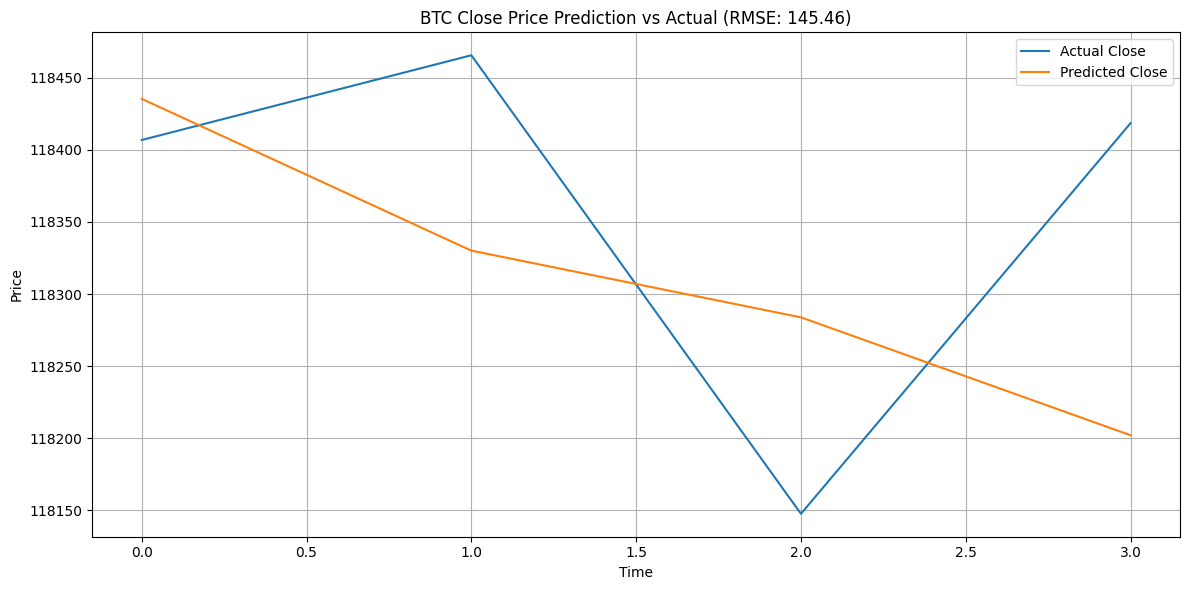

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import math

# Predict
y_pred = model.predict(X_val)

# Inverse scale predictions
scaled_pred = np.zeros((len(y_pred), 5))
scaled_pred[:, 3] = y_pred.flatten()
predicted_close = scaler.inverse_transform(scaled_pred)[:, 3]

# Inverse scale actuals (use y_val, not X_val!)
scaled_actual = np.zeros((len(y_val), 5))
scaled_actual[:, 3] = y_val.flatten()
actual_close = scaler.inverse_transform(scaled_actual)[:, 3]

# Optional: RMSE
rmse = math.sqrt(mean_squared_error(actual_close, predicted_close))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title(f"BTC Close Price Prediction vs Actual (RMSE: {rmse:.2f})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,957 (210.77 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,972 (140.52 KB)

#### ✅ 3. Use with the flexible input prediction function
Here's the complete function that:

Loads from a CSV

Uses the last N timesteps before a user-specified datetime

Predicts the next hour’s Close price

In [4]:
def predict_n_hours_ahead_from_csv(model, csv_path, input_datetime_str, seq_len=12):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    # Ask user how far into the future to predict
    future_str = input("How far ahead to predict? (e.g., '3d' for 3 days, '12h' for 12 hours): ").strip().lower()
    if future_str.endswith('d'):
        hours_ahead = int(future_str[:-1]) * 24
    elif future_str.endswith('h'):
        hours_ahead = int(future_str[:-1])
    else:
        raise ValueError("Invalid input format. Use 'Nd' for days or 'Nh' for hours.")

    # Load and prepare data
    df = pd.read_csv(csv_path, parse_dates=["Datetime"])
    df = df.sort_values("Datetime")

    # Localize user input to UTC
    input_datetime = pd.to_datetime(input_datetime_str).tz_localize("UTC")

    # Get last `seq_len` rows before given timestamp
    prev_data = df[df["Datetime"] < input_datetime].tail(seq_len)
    if len(prev_data) < seq_len:
        raise ValueError(f"Need at least {seq_len} rows before {input_datetime}, only found {len(prev_data)}")

    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler()
    scaled_seq = scaler.fit_transform(prev_data[features])

    preds = []
    timestamps = []

    for i in range(hours_ahead):
        # Prepare input shape for LSTM
        X_input = np.expand_dims(scaled_seq, axis=0)
        pred_scaled = model.predict(X_input, verbose=0)

        # Inverse scale: we only have predicted Close, so we place it in the 3rd column
        dummy = np.zeros((1, 5))
        dummy[0, 3] = pred_scaled
        predicted_row = scaler.inverse_transform(dummy)[0]

        preds.append(predicted_row[3])

        # Update timestamps
        last_time = input_datetime if i == 0 else timestamps[-1]
        timestamps.append(last_time + pd.Timedelta(hours=1))

        # ⚠️ Update only Close; others copied from last known row (not ideal but acceptable if model is Close-only)
        last_known_scaled = scaled_seq[-1].copy()
        last_known_scaled[3] = pred_scaled  # Update just the Close value

        scaled_seq = np.vstack([scaled_seq[1:], last_known_scaled])

    # Output predictions
    for t, p in zip(timestamps, preds):
        print(f"📈 Predicted Close at {t} is ${p:.2f}")


In [6]:
# model = load_model(model_path, compile=False)
# predict_n_hours_ahead_from_csv(model, csv_path, "2025-07-21 20:00")


from tensorflow.keras.models import load_model  # ← Add this

model_path = "/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/crypto_lstm_model_finetuned_v2.h5"
csv_path = "/content/drive/MyDrive/BTC_Prediction_Training/data/btc_21_July_to_23_July.csv"

model = load_model(model_path, compile=False)
predict_n_hours_ahead_from_csv(model, csv_path, "2025-07-23 15:30")

How far ahead to predict? (e.g., '3d' for 3 days, '12h' for 12 hours): 7h


/tmp/ipython-input-4-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-4-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_scaled[3] = pred_scaled  # Update just the Close value
/tmp/ipython-input-4-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-4-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 

📈 Predicted Close at 2025-07-23 16:30:00+00:00 is $118367.17
📈 Predicted Close at 2025-07-23 17:30:00+00:00 is $118394.40
📈 Predicted Close at 2025-07-23 18:30:00+00:00 is $118454.35
📈 Predicted Close at 2025-07-23 19:30:00+00:00 is $118532.47
📈 Predicted Close at 2025-07-23 20:30:00+00:00 is $118614.06
📈 Predicted Close at 2025-07-23 21:30:00+00:00 is $118690.89
📈 Predicted Close at 2025-07-23 22:30:00+00:00 is $118763.46


/tmp/ipython-input-4-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-4-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_scaled[3] = pred_scaled  # Update just the Close value
